In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import time

import cv2
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

from utils import (read_frames, extract_motion, weighted_gaussian_smooth,
                   get_fft_results, find_peak_idxs, prompt_clicks,
                   get_cube_model, keypoints_from_clicks, gather_image_space_modes,
                   get_observed_modal_data, get_solver)
from utils import (plot_motion_field, find_nearest, normalize_modes,
                   interpolate_2d_motion, freqs_to_eigvals, projection_matrix_from_keypoints,
                   full_mode_matrix, weighted_sum, project_and_interpolate_motion,
                   plot_3d_cube)
from utils import gather_modal_data_across_videos

In [3]:
"""
Define an inference cube model.
The inference cube's dimensions are based on the measured
width, length, and height of the real cube.
"""

# Measured dimensions [m]:
XLEN = 0.049
YLEN = 0.047
ZLEN = 0.045

# Number of voxels in each direction:
NX = NY = NZ = 10
N_VOX = NX * NY * NZ

# Homogeneous Poisson's ratio:
NU = 0.43

# Mesh element order:
DEGREE = 1

# Inference cube model:
cube = get_cube_model(XLEN, YLEN, ZLEN, NX, NY, NZ, NU, DEGREE)

Element mass mats: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.59it/s]


## Average Modal Observations
There are three videos of this cube, each corresponding to a different initial condition (a.k.a. "forcing"):
1. top-front-pluck
2. top-right-pluck
3. left-side-twist

We assume that modal observations have already been obtained through motion extraction for each video. Each video's modal observations should be saved as a pickled dictionary `info_dict_{NX}x{NY}x{NZ}_deg{DEGREE}.pkl`. We assume that the pixel locations of reference keypoints have already been saved as `clicks.npy` for each video.

For each unique mode, we average its observations across the three videos (a mode doesn't necessarily appear in each video). The six unique modes have already been identified qualitatively.

In [12]:
"""
Gather the image-space modal observations across all the videos.
"""
videos = ['top_front_pluck', 'top_right_pluck', 'left_side_twist']
modal_data_file = 'info_dict_%dx%dx%d_deg%d.pkl' % (NX, NY, NZ, DEGREE)
modal_data_files = [
    os.path.join('real_data', 'jello_cube', video, modal_data_file) \
    for video in videos
]

modal_data = gather_modal_data_across_videos(modal_data_files)
modes_dx = modal_data['obs_modes_dx']
modes_dy = modal_data['obs_modes_dy']
freqs = modal_data['obs_freqs']

Gathering modal observation data from:
  * real_data/jello_cube/top_front_pluck/info_dict_10x10x10_deg1.pkl
  * real_data/jello_cube/top_right_pluck/info_dict_10x10x10_deg1.pkl
  * real_data/jello_cube/left_side_twist/info_dict_10x10x10_deg1.pkl


In [13]:
"""
Sample image-space modes at visible mesh vertices for each video.
"""
keypoints_per_video = [
    keypoints_from_clicks(np.load('real_data/jello_cube/%s/clicks.npy' % video), NX, NY, NZ) \
    for video in videos
]

modes_3d = []
for video_idx in range(len(videos)):
    U_obs_in_video = get_observed_modal_data(
        modes_dx[video_idx],
        modes_dy[video_idx],
        keypoints_per_video[video_idx],
        cube.n_dofs,
        cube.image_space_dofs)
    modes_3d.append(U_obs_in_video)

In [38]:
"""
Average observations of each unique mode across all videos. The averaged
modes serve as the data used for material-property inference.
A unique mode is defined by the (video, mode_number, sign) triple for each
video in which it appears. The sign is not necessary, but for the sake of 
reproducing Fig. 11, we need to flip one of the modes from one of the videos.
The frequencies of the unique modes are also averaged across the videos.
Note: Fig. 10 shows one of the observed frequencies (not the average) for
each unique mode.
"""
n_unique_modes = 6
unique_modes = {
    0: [('top_front_pluck', 0, 1), ('top_right_pluck', 0, 1), ('left_side_twist', 0, 1)],
    1: [('top_front_pluck', 1, 1), ('top_right_pluck', 1, -1), ('left_side_twist', 1, 1)],
    2: [('top_right_pluck', 2, 1)],
    3: [('left_side_twist', 2, 1)],
    4: [('top_front_pluck', 2, 1)],
    5: [('top_right_pluck', 3, 1)]
}

U_observed = np.zeros((cube.n_dofs, n_unique_modes))
freqs_observed = np.zeros(n_unique_modes)
for unique_mode_idx, unique_mode in unique_modes.items():
    n_obs = len(unique_mode)
    avg_3d_mode = sum([obs[2] * modes_3d[videos.index(obs[0])][:, obs[1]] \
                       for obs in unique_mode]) / n_obs
    avg_freq = sum([freqs[videos.index(obs[0])][obs[1]] for obs in unique_mode]) / n_obs
    U_observed[:, unique_mode_idx] = avg_3d_mode
    freqs_observed[unique_mode_idx] = avg_freq

U_observed = normalize_modes(U_observed)

In [ ]:
# """
# View raw image-space mode for a specified video and mode number (0-indexed).
# """
# video = 'top_front_pluck'
# mode_number = 0
# video_number = videos.index(video)

# dx = modes_dx[video_number][mode_number].real
# dy = modes_dy[video_number][mode_number].real
# freq = freqs[video_number][mode_number]

# fig = plt.figure(figsize=(7, 6), constrained_layout=True)
# fig.suptitle(
#     '[%s] mode %d: %.2f Hz' % (video, mode_number, freq), fontsize=25)

# plt.subplot(221)
# plot_motion_field(dx, cbar=False, origin='lower')
# plt.axis('off')

# plt.subplot(222)
# plot_motion_field(dy, cbar=False, origin='lower')
# plt.axis('off')
# plt.show()

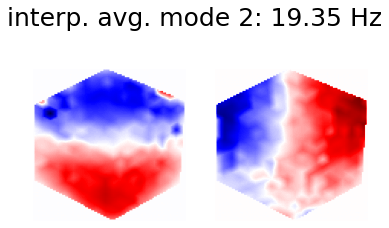

In [39]:
"""
View interpolated, averaged image-space mode for a specified mode number (0-indexed).
To do the 2D interpolation, we need the pixel locations of the reference mesh points,
e.g., in `real_data/jello_cube/top_front_pluck/clicks.npy`.
"""
mode_number = 2

# Get pixel locations of visible mesh vertices.
reference_keypoints = np.load('real_data/jello_cube/top_front_pluck/clicks.npy')
keypoints = keypoints_from_clicks(reference_keypoints, NX, NY, NZ)

mode_2d = U_observed[cube.image_space_dofs, mode_number].reshape(-1, 3)[:, :2]
freq = freqs_observed[mode_number]
dx, dy = interpolate_2d_motion(keypoints, mode_2d)

fig = plt.figure()
fig.suptitle(
    'interp. avg. mode %d: %.2f Hz' % (mode_number, freq),
    fontsize=25)
plt.subplot(121)
plot_motion_field(dx, cbar=False, origin='lower')

plt.subplot(122)
plot_motion_field(dy, cbar=False, origin='lower')
plt.show()

## Material-Property Inference

In [40]:
"""
Initialize Solver and set the modal data used for material-property estimation.
"""
proj_mat = projection_matrix_from_keypoints(cube, keypoints, flip_y=False)
solver = get_solver(cube, proj_mat)

U_input = U_observed[cube.nonbc_dofs]
eigvals_input = freqs_to_eigvals(freqs_observed)

solver.update_observations(U_input, eigvals_input)
print('%d input modes' % solver.k)

Gather element mats: 100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 633.09it/s]


6 input modes


In [41]:
"""
Set the hyperparameters of the optimization problem that is solved
to estimate the material properties.
"""
w_init = 10000  # initial homog. Young's modulus (in Pa)
v_init = 1500   # initial homog. density (in kg/m3)
solver.params['alpha_u'] = 0.1
solver.params['alpha_w'] = 1e-10 / N_VOX
solver.params['alpha_v'] = 1e-8 / N_VOX
solver.params['alpha_e'] = 1
solver.params['scale_reg_type'] = 'mean'
solver.params['alpha_w_mean'] = 1
solver.params['alpha_v_mean'] = 0
solver.params['w_mean'] = w_init
solver.params['v_mean'] = v_init

eta = 1
norm_converge_thresh = 5e-3

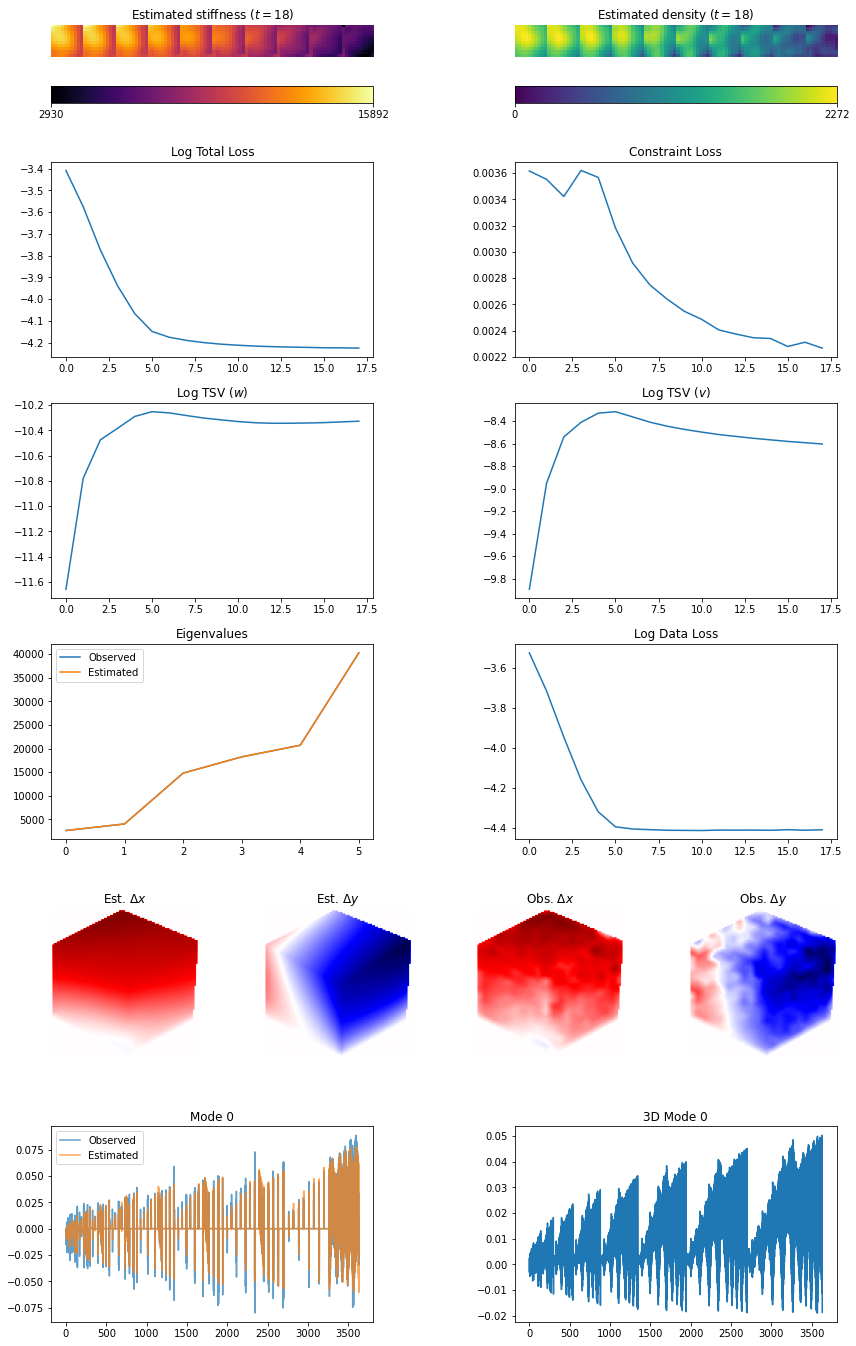

[t=017] 10.825 sec, w residual norm: 0.003381, v residual norm: 0.005029
Converged! (w residual norm = 0.003285, v residual norm = 0.004922)


In [42]:
"""
Run the iterative optimization algorithm, plotting the progress
at each step.
"""
initialize = True
n_iter = 100

Uo_full = full_mode_matrix(solver.Uo, cube.n_dofs, cube.nonbc_dofs)

if initialize:
    evalst = solver.evals_observed.copy()
    Ut = solver.Uo.copy()
    wt = np.ones(N_VOX) * w_init
    vt = np.ones(N_VOX) * v_init
    
    Kt = weighted_sum(solver.element_stiffness_mats, wt)
    Mt = weighted_sum(solver.element_mass_mats, vt)
    
    dual_vars = np.ones(solver.k) * 1
    
    losses_dict = {
        'total': [],
        'constr': [],
        'constr_unw': [],
        'data': [],
        'eigval_data': [],
        'tsv_w': [],
        'tsv_v': [],
        'scale_reg': []
    }
    
w_prev, v_prev = wt, vt
start_t = len(losses_dict['total'])
for t in range(start_t, start_t + n_iter):
    iter_start = time.time()
    
    # Solve modes.
    Ut = solver.solve_U(Kt, Mt, evalst, dual_vars)
    
    # Solve eigenvalues.
    evalst = solver.solve_evals(Kt, Mt, Ut, dual_vars)
    
    # Update dual variables.
    dual_vars = solver.update_dual_vars(Kt, Mt, Ut, evalst, dual_vars, eta)
    
    # Solve material properties.
    wv = solver.solve_w_v(
        Ut, evalst, dual_vars, enforce_pos=True)
    wt = wv[:solver.n_weights]
    vt = wv[solver.n_weights:]
    Kt = weighted_sum(solver.element_stiffness_mats, wt)
    Mt = weighted_sum(solver.element_mass_mats, vt)
    
    # Update losses.
    unw_loss_dict, loss_dict = solver.loss(Ut, evalst, Kt, Mt, wt, vt, dual_vars)
    for loss_term in loss_dict.keys():
        losses_dict[loss_term].append(loss_dict[loss_term])
    losses_dict['constr_unw'].append(unw_loss_dict['constr'])
        
    # Check solution convergence.
    w_residual = wt - w_prev
    v_residual = vt - v_prev
    w_residual_norm = np.linalg.norm(w_residual) / np.linalg.norm(w_prev)
    v_residual_norm = np.linalg.norm(v_residual) / np.linalg.norm(v_prev)
    if w_residual_norm <= norm_converge_thresh and v_residual_norm <= norm_converge_thresh:
        print('Converged! (w residual norm = %.6f, v residual norm = %.6f)'
              % (w_residual_norm, v_residual_norm))
        break
    w_prev, v_prev = wt, vt
    
    # Plot progress.
    Ut_full = full_mode_matrix(Ut, cube.n_dofs, cube.nonbc_dofs)
    Ut_proj = solver.P @ Ut
    
    fig = plt.figure(figsize=(12, 20))
    
    plt.subplot(621)
    cube.plot_2d(wt, cmap='inferno')
    plt.axis('off')
    plt.title("Estimated stiffness ($t=%d$)" % (t+1))
    
    plt.subplot(622)
    cube.plot_2d(vt, cmap='viridis')
    plt.axis('off')
    plt.title("Estimated density ($t=%d$)" % (t+1))
    
    # Plot losses.
    plt.subplot(623)
    plt.plot(np.log(losses_dict['total']))
    plt.title('Log Total Loss')
    
    plt.subplot(624)
    plt.plot(losses_dict['constr'])
    plt.title('Constraint Loss')
    
    plt.subplot(625)
    plt.plot(np.log(losses_dict['tsv_w']))
    plt.title('Log TSV ($w$)')
    
    plt.subplot(626)
    plt.plot(np.log(losses_dict['tsv_v']))
    plt.title('Log TSV ($v$)')
    
    plt.subplot(627)
    plt.plot(solver.evals_observed, label='Observed')
    plt.plot(evalst, label='Estimated')
    plt.legend()
    plt.title('Eigenvalues')
    
    ax = fig.add_subplot(6, 2, 8)
    ax.plot(np.log(losses_dict['data']))
    ax.set_title('Log Data Loss')

    # Visualize random mode.
    i = np.random.randint(0, solver.k)
    
    # Estimated mode:
    est_mode_3d = Ut_full[cube.image_space_dofs, i].reshape(-1, 3)
    est_mode_dx, est_mode_dy = project_and_interpolate_motion(
        keypoints, est_mode_3d, proj_mat)
    
    ax = fig.add_subplot(6, 4, 17)
    plot_motion_field(
        est_mode_dx, fig=fig, ax=ax, cbar=False, origin='lower')
    ax.set_title('Est. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 18)
    plot_motion_field(
        est_mode_dy, fig=fig, ax=ax, cbar=False, origin='lower')
    ax.set_title('Est. $\Delta$$y$')
    
    # Observed mode:
    obs_mode_2d = Uo_full[cube.image_space_dofs, i].reshape(-1, 3)[:, :2]
    obs_mode_dx, obs_mode_dy = interpolate_2d_motion(
        keypoints, obs_mode_2d)
    
    ax = fig.add_subplot(6, 4, 19)
    plot_motion_field(
        obs_mode_dx, fig=fig, ax=ax, cbar=False, origin='lower')
    ax.set_title('Obs. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 20)
    plot_motion_field(
        obs_mode_dy, fig=fig, ax=ax, cbar=False, origin='lower')
    ax.set_title('Obs. $\Delta$$y$')
    
    # 1d mode comparison:
    ax = fig.add_subplot(6, 2, 11)
    ax.plot(solver.Uo[:, i], alpha=0.7, label='Observed')
    ax.plot(Ut_proj[:, i], alpha=0.7, label='Estimated')
    ax.legend()
    ax.set_title('Mode %d' % i)
    
    # 3D mode:
    ax = fig.add_subplot(6, 2, 12)
    ax.plot(Ut[:,i] / np.linalg.norm(Ut[:,i]))
    ax.set_title('3D Mode %d' % i)
    
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(plt.gcf())
    plt.close('all')
    
    print('[t=%03d] %.3f sec, w residual norm: %.6f, v residual norm: %.6f'
          % (t, time.time() - iter_start, w_residual_norm, v_residual_norm))

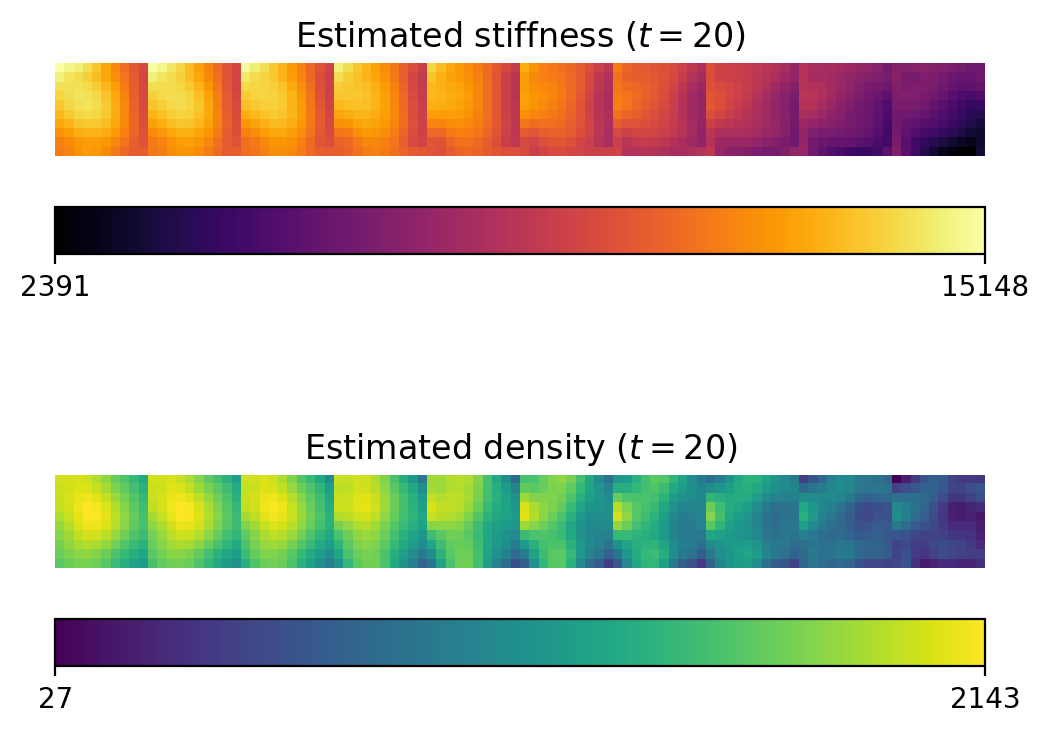

In [37]:
fig = plt.figure(figsize=(6, 5), dpi=200)
plt.subplot(211)
cube.plot_2d(wt, cmap='inferno')
plt.axis('off')
plt.title("Estimated stiffness ($t=%d$)" % (t+1))

plt.subplot(212)
cube.plot_2d(vt, cmap='viridis')
plt.axis('off')
plt.title("Estimated density ($t=%d$)" % (t+1))
plt.show()